In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

## 1. Objective

1. Inspect the remainder between the target (passengers) and our previous prediction using the trend and seasonality
2. Introduce the concept of Autoregression
3. Build an autoregression model of order AR1
4. Introduce a the concepts of auto-correlation and partial-auto-correlation
5. Understand how to use partial-auto-correlation to choose AR model order
6. Examine the residuals of AR model

## 2. Recap questions

### Q. How did the data look like ?

In [2]:
flights_train  = pd.read_csv("flights_train.csv", parse_dates=True, index_col='date')

flights_train.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


In [3]:
def plot_timeseries (df, title=" ", ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    
    df.plot()
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("Passengers in 1000s")
    plt.show()

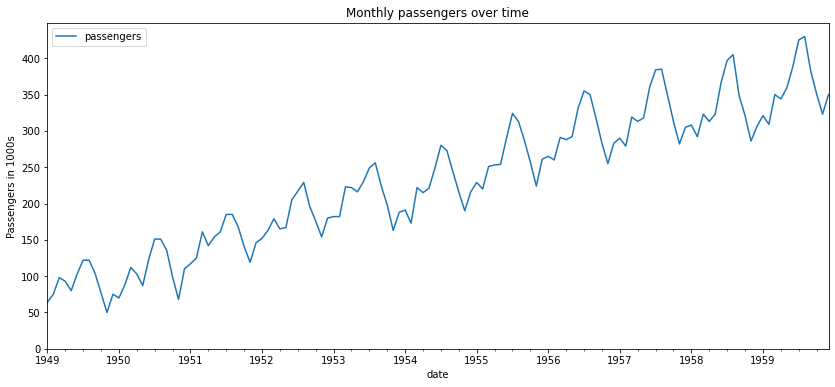

In [4]:
plot_timeseries(flights_train, title="Monthly passengers over time")

### Q: How did we extract trend ?  


In [5]:
# we had to engineer a feature to add to our data that represents the time step/increment over time 

flights_train['timestep'] = list(range(len(flights_train)))
flights_train.head()

,passengers,timestep
date,,
1949-01-01,64,0
1949-02-01,75,1
1949-03-01,98,2
1949-04-01,93,3
1949-05-01,80,4


In [6]:
m_trend = LinearRegression()

X = flights_train[['timestep']]
y = flights_train[['passengers']]

m_trend.fit(X, y)

LinearRegression()

In [7]:
flights_train['trend'] = m_trend.predict(X)

flights_train.head()

,passengers,timestep,trend
date,,,
1949-01-01,64,0,79.444293
1949-02-01,75,1,81.761937
1949-03-01,98,2,84.079581
1949-04-01,93,3,86.397226
1949-05-01,80,4,88.714870


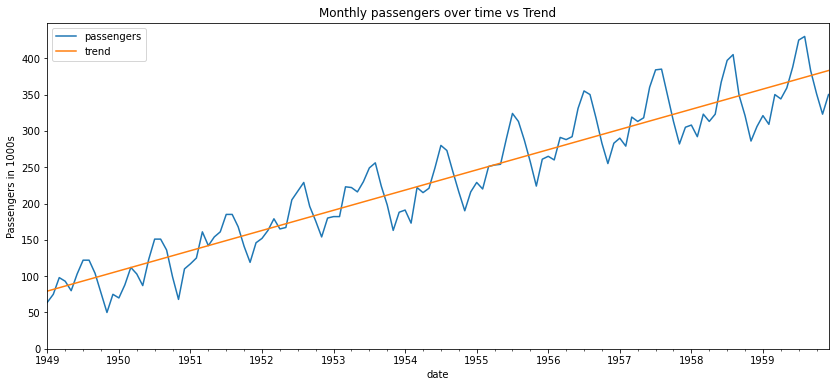

In [8]:
plot_timeseries(flights_train[['passengers', 'trend']], title="Monthly passengers over time vs Trend")

### Q: how did we detect that there is seasonality ? How did we model seasonality ?

In [9]:
flights_train['year'] = flights_train.index.year
flights_train['month'] = flights_train.index.month
flights_train['month_name'] = flights_train.index.month_name()


flights_train.head()

,passengers,timestep,trend,year,month,month_name
date,,,,,,
1949-01-01,64,0,79.444293,1949,1,January
1949-02-01,75,1,81.761937,1949,2,February
1949-03-01,98,2,84.079581,1949,3,March
1949-04-01,93,3,86.397226,1949,4,April
1949-05-01,80,4,88.714870,1949,5,May


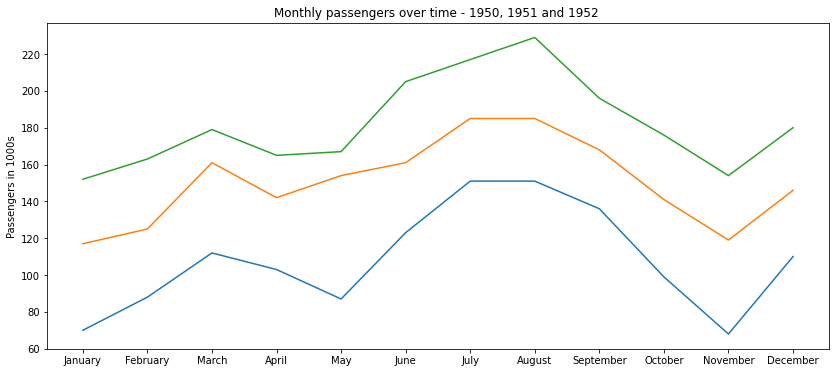

In [10]:
fig, ax = plt.subplots()

flights_1950 = flights_train[flights_train['year']==1950]
flights_1951 = flights_train[flights_train['year']==1951]
flights_1952 = flights_train[flights_train['year']==1952]

ax.plot(flights_1950['month_name'], flights_1950['passengers'])
ax.plot(flights_1951['month_name'], flights_1951['passengers'])
ax.plot(flights_1952['month_name'], flights_1952['passengers'])


plt.title ("Monthly passengers over time - 1950, 1951 and 1952 ")
plt.ylabel("Passengers in 1000s")
plt.show()

In [11]:
# hot-one encode month column

pd.get_dummies(flights_train[['passengers', 'timestep', 'month_name', 'trend']], prefix = '', prefix_sep='')

,passengers,timestep,trend,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,
1949-01-01,64,0,79.444293,0,0,0,0,1,0,0,0,0,0,0,0
1949-02-01,75,1,81.761937,0,0,0,1,0,0,0,0,0,0,0,0
1949-03-01,98,2,84.079581,0,0,0,0,0,0,0,1,0,0,0,0
1949-04-01,93,3,86.397226,1,0,0,0,0,0,0,0,0,0,0,0
1949-05-01,80,4,88.714870,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959-08-01,430,127,373.785130,0,1,0,0,0,0,0,0,0,0,0,0
1959-09-01,383,128,376.102774,0,0,0,0,0,0,0,0,0,0,0,1
1959-10-01,351,129,378.420419,0,0,0,0,0,0,0,0,0,0,1,0


In [12]:
flights_train = pd.get_dummies(flights_train, prefix = '', prefix_sep='', drop_first=True)

flights_train.head()

,passengers,timestep,trend,year,month,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,
1949-01-01,64,0,79.444293,1949,1,0,0,0,1,0,0,0,0,0,0,0
1949-02-01,75,1,81.761937,1949,2,0,0,1,0,0,0,0,0,0,0,0
1949-03-01,98,2,84.079581,1949,3,0,0,0,0,0,0,1,0,0,0,0
1949-04-01,93,3,86.397226,1949,4,0,0,0,0,0,0,0,0,0,0,0
1949-05-01,80,4,88.714870,1949,5,0,0,0,0,0,0,0,1,0,0,0


In [13]:
# now we fit another model that captures both trend and seasonality

X = flights_train.drop(['trend', 'month', 'passengers', 'year'], axis=1)
y = flights_train['passengers']

m_trend_seasonal = LinearRegression()

m_trend_seasonal.fit(X, y)

flights_train['trend_seasonal'] = m_trend_seasonal.predict(X)

flights_train.head()

,passengers,timestep,trend,year,month,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,,,,
1949-01-01,64,0,79.444293,1949,1,0,0,0,1,0,0,0,0,0,0,0,59.594697
1949-02-01,75,1,81.761937,1949,2,0,0,1,0,0,0,0,0,0,0,0,57.503788
1949-03-01,98,2,84.079581,1949,3,0,0,0,0,0,0,1,0,0,0,0,90.503788
1949-04-01,93,3,86.397226,1949,4,0,0,0,0,0,0,0,0,0,0,0,83.412879
1949-05-01,80,4,88.714870,1949,5,0,0,0,0,0,0,0,1,0,0,0,85.231061


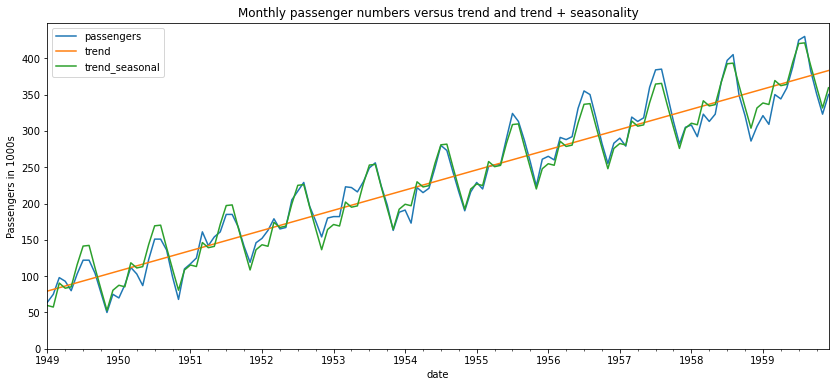

In [14]:
plot_timeseries(flights_train[['passengers', 'trend', 'trend_seasonal']], 
                title = 'Monthly passenger numbers versus trend and trend + seasonality')

### Q: Plot the remainder over time ? Does it look completely random ?

In [15]:
flights_train['remainder'] = flights_train['passengers'] - flights_train['trend_seasonal']

flights_train.head()

,passengers,timestep,trend,year,month,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,
1949-01-01,64,0,79.444293,1949,1,0,0,0,1,0,0,0,0,0,0,0,59.594697,4.405303
1949-02-01,75,1,81.761937,1949,2,0,0,1,0,0,0,0,0,0,0,0,57.503788,17.496212
1949-03-01,98,2,84.079581,1949,3,0,0,0,0,0,0,1,0,0,0,0,90.503788,7.496212
1949-04-01,93,3,86.397226,1949,4,0,0,0,0,0,0,0,0,0,0,0,83.412879,9.587121
1949-05-01,80,4,88.714870,1949,5,0,0,0,0,0,0,0,1,0,0,0,85.231061,-5.231061


In [16]:
flights_train.shape

(132, 18)

In [17]:
# plot and compare with a random signal

flights_train['random'] = np.random.normal(loc=0, scale=10, size=flights_train.shape[0])


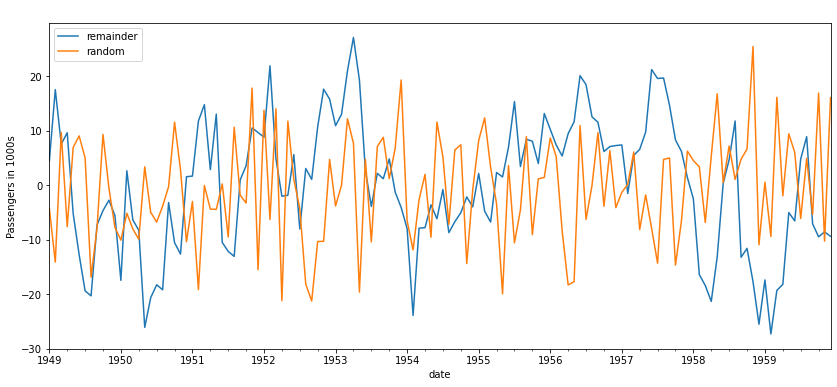

In [18]:
plot_timeseries(flights_train[['remainder', 'random']], ylim=False)

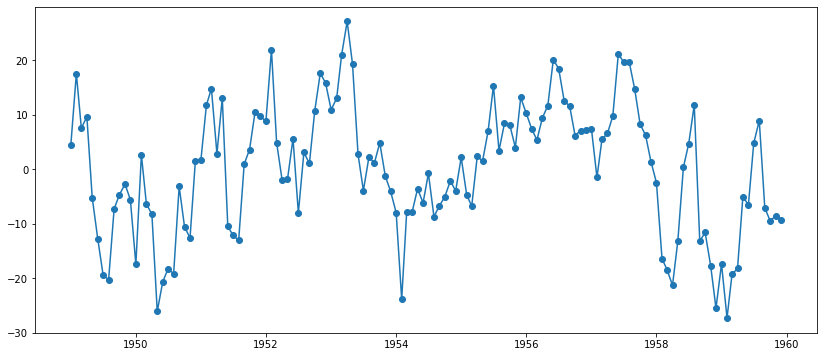

In [19]:
fig, ax = plt.subplots()
ax.plot(flights_train.index, flights_train['remainder'], marker='o')
plt.show()

what we noticed here:

1. Remainder differs from the random signal 
2. It seems that there is a relationship/correlation between the value of the remainder at time t and time t+1 possibly later time instants as well 


### Q: How can we check our observation ? 

## 3. Creating a time lagged version of our data. 

In [20]:
remainder = flights_train[['remainder']].copy()

remainder.head()

,remainder
date,
1949-01-01,4.405303
1949-02-01,17.496212
1949-03-01,7.496212
1949-04-01,9.587121
1949-05-01,-5.231061


### We have to create a time-lagged feature of the remainder

In [21]:
remainder['lag1'] = remainder.shift(1)

remainder.head()

,remainder,lag1
date,,
1949-01-01,4.405303,NaN
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121


### and then calculate the correlation between them

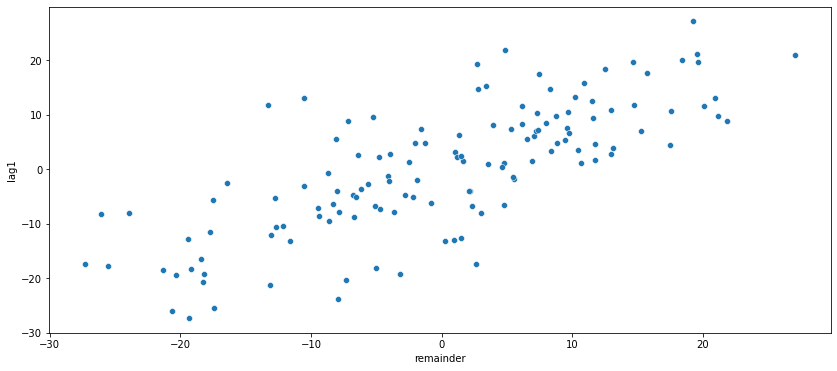

In [22]:
sns.scatterplot(x='remainder',  y='lag1', data=remainder);

In [23]:
remainder['remainder'].corr(remainder['lag1'])

0.7582264931719601

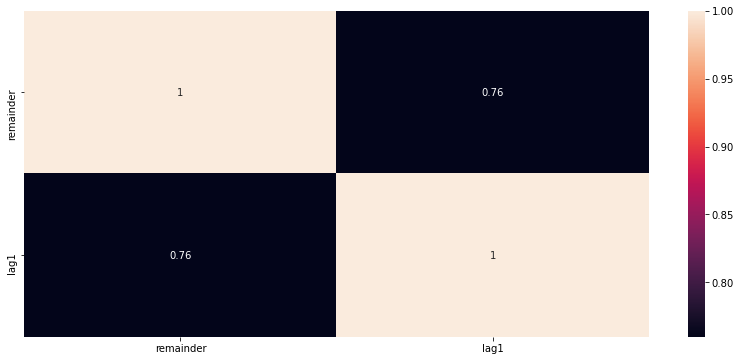

In [24]:
sns.heatmap(round(remainder.corr(), 2), annot=True);

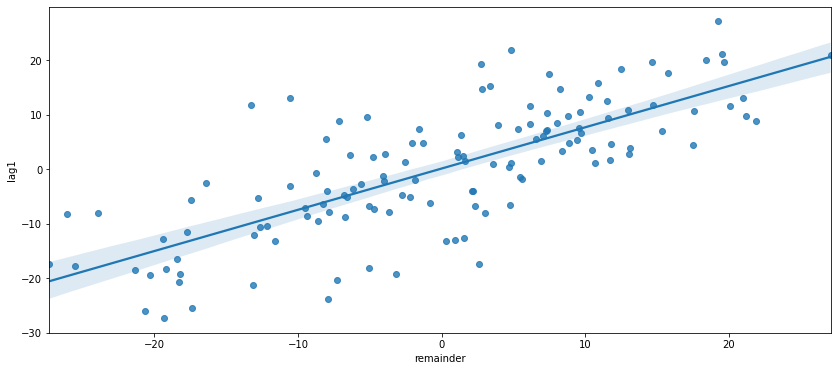

In [25]:
sns.regplot(x = remainder['remainder'], y = remainder['lag1'], fit_reg=True, scatter=True);

### Q: How can we use the correlation with the lagged version to get a better model of our target (passengers) ?

## 4. Autoregressive models (AR(n))

Now we are ready to talk about the autoregressive model. In the autoregressive model we model the future value of a variable by looking at the present (and maybe past) value of the same variable. In our case the variable will be the **remainder**.

$$
y_{t+1} = w_0 + \sum_{j=0}^{P-1}w_{j}y_{t-j} + \epsilon_t
$$

where $t$ is the current timestep, $w_0$ is the bias/intercept, the w’s are the weights of the model and $\epsilon$ is some **iid** (e.g. Gaussian - more on this in the afternoon) noise. **P** is the number of lags to use for the model. It is a hyperparameter that we have to choose.

**AR(1) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t}
$$

or in case of our remainder

$$
\hat{remainder_{t+1}} = w_0 + w_1 * remainder_{t}
$$

In an AR(1) model we model the value in $t+1$ as a linear function of the value in $t$.

**AR(2) - Model**

$$
\hat{y_{t+1}} = w_0 + w_1 * y_{t} + w_2 * y_{t-1}
$$

## 5. Run an AR(1) on remainder series

In [26]:
remainder.head()

,remainder,lag1
date,,
1949-01-01,4.405303,NaN
1949-02-01,17.496212,4.405303
1949-03-01,7.496212,17.496212
1949-04-01,9.587121,7.496212
1949-05-01,-5.231061,9.587121


In [27]:
remainder_copy = remainder.copy()

In [28]:
# we have to drop the NaN
remainder.dropna(inplace=True)

In [29]:
# simply a linear regression



X = remainder[['lag1']]
y = remainder['remainder']

m_ar = LinearRegression()

m_ar.fit(X, y)

remainder['prediction_ar1'] = m_ar.predict(X)

remainder.head()

,remainder,lag1,prediction_ar1
date,,,
1949-02-01,17.496212,4.405303,3.258369
1949-03-01,7.496212,17.496212,13.203025
1949-04-01,9.587121,7.496212,5.606413
1949-05-01,-5.231061,9.587121,7.194795
1949-06-01,-12.776515,-5.231061,-4.062003


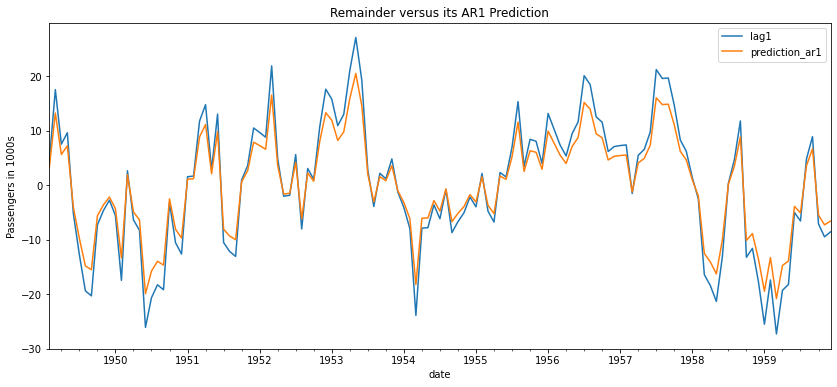

In [30]:
# let's plot the remainder and its AR(1) prediction

plot_timeseries(remainder[['lag1', 'prediction_ar1']], title="Remainder versus its AR1 Prediction", ylim=False)

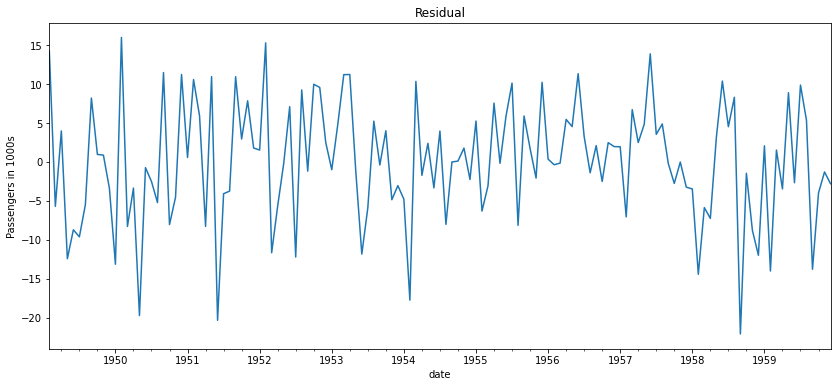

In [31]:
remainder['residual'] = remainder['remainder'] - remainder['prediction_ar1']

plot_timeseries(remainder['residual'], title="Residual", ylim=False)

What do we observe ? Does the residual look like random noise ?

## 6. Should we take additional lags into consideration ? AR(2) model ?

## How can we find out ?

In [32]:
remainder['lag2'] = remainder['remainder'].shift(2)

In [33]:
remainder.head()

,remainder,lag1,prediction_ar1,residual,lag2
date,,,,,
1949-02-01,17.496212,4.405303,3.258369,14.237843,NaN
1949-03-01,7.496212,17.496212,13.203025,-5.706813,NaN
1949-04-01,9.587121,7.496212,5.606413,3.980709,17.496212
1949-05-01,-5.231061,9.587121,7.194795,-12.425856,7.496212
1949-06-01,-12.776515,-5.231061,-4.062003,-8.714512,9.587121


In [34]:
remainder['remainder'].corr(remainder['lag2'])

0.6022865812268725

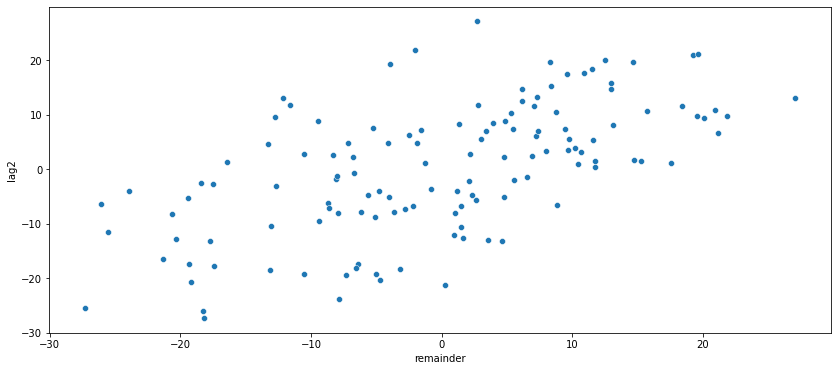

In [35]:
sns.scatterplot(x='remainder',  y='lag2', data=remainder);

<AxesSubplot:>

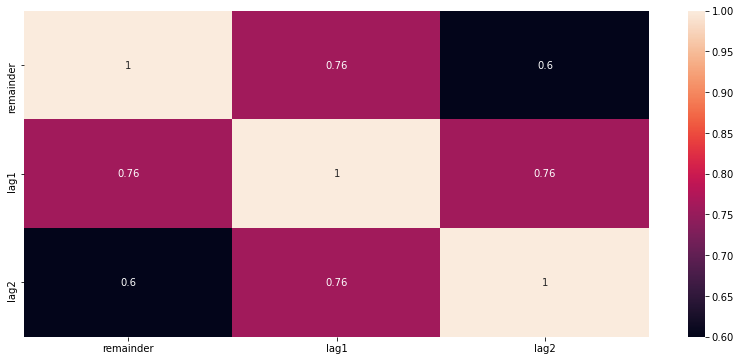

In [36]:
sns.heatmap(round(remainder[['remainder', 'lag1', 'lag2']].corr(), 2), annot=True)

In [37]:
0.76*0.76

0.5776

## 7. Tools to find out how many lags to include in our AR model

### 7.1 Method 1

### Q: What is correlation ?  What is auto-correlation ?

**Correlation:** Relationship between variables. In the case of **auto-correlation**  we are looking at the same variable at different time steps in the same series. 

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})} {\sigma^2(y_t)\, \sigma^2( y_{t-h})} 
$$

**Covariance:** Think about it as variance of two variables with each other. 

https://www.mygreatlearning.com/blog/covariance-vs-correlation/#differencebetweencorrelationandcovariance

Check out pd.cov(), pd.corr().

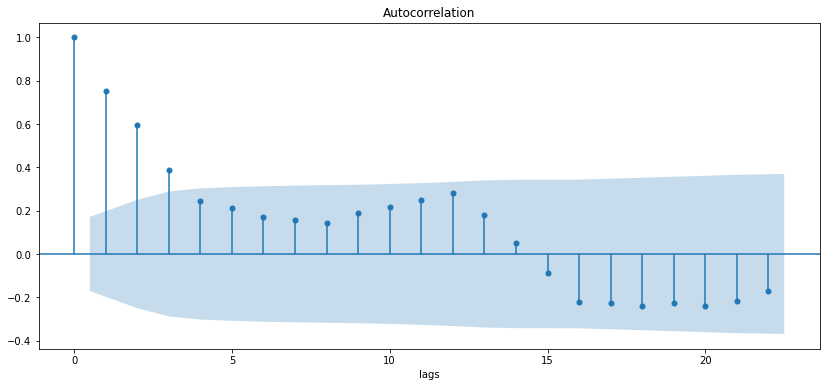

In [38]:
# we can plot auto-correlation with stats model

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(remainder['remainder'])
plt.xlabel('lags');

### Q: What is partial autocorrelation ?

One tool to find out how many lags we should include into our Autoregressive Model is to plot the Partial Autocorrelation between different lags. What is the Partial Autocorrelation?

$$
\delta_h = Corr(y_t, y_{t-h}|y_{t-1}, ..., y_{t-h+1})
$$

PACF is the correlation between $y_t$ and $y_{t−h}$, conditional on the intermediate values (eg. $y_{t-1}$, $y_{t-2}$, ...). 

They are basically nothing else than the coefficients in a linear regression if you included h lags.

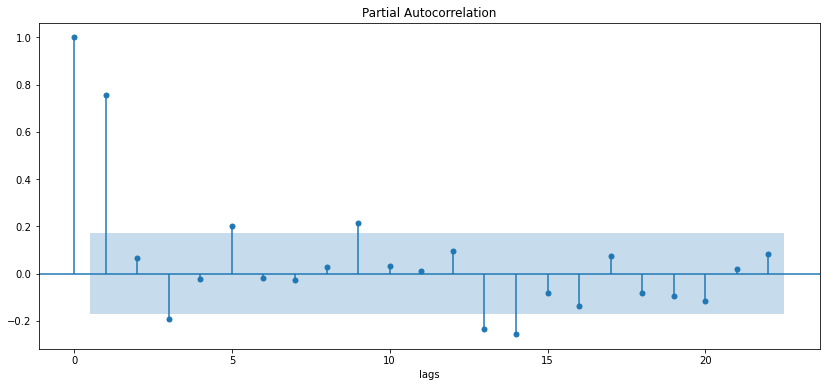

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(remainder['remainder'])
plt.xlabel('lags');

Box-Jenkins Methodology of choosing order in an AR(n)

### 7.2 Method 2

In [40]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [46]:
selected_order = ar_select_order(remainder_copy['remainder'], maxlag = 12)

In [47]:
selected_order.ar_lags

array([1])

In [48]:
stats_ar1 = AutoReg(remainder_copy['remainder'], lags=1).fit()

In [49]:
stats_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  132
Model:                     AutoReg(1)   Log Likelihood                -453.876
Method:               Conditional MLE   S.D. of innovations              7.735
Date:                Thu, 17 Jun 2021   AIC                              4.137
Time:                        18:31:38   BIC                              4.203
Sample:                    02-01-1949   HQIC                             4.164
                         - 12-01-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0882      0.676     -0.130      0.896      -1.413       1.236
remainder.L1     0.7597      0.057     13.310      0.000       0.648       0.872
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3164           +0.0000j            1.3164            0.0000
-----------------------------------------------------------------------------
"""

In [50]:
stats_ar1.predict()

1949-01-01          NaN
1949-02-01     3.258369
1949-03-01    13.203025
1949-04-01     5.606413
1949-05-01     7.194795
                ...    
1959-08-01     3.540364
1959-09-01     6.648069
1959-10-01    -5.506510
1959-11-01    -7.302073
1959-12-01    -6.611472
Freq: MS, Length: 132, dtype: float64

In [51]:
remainder['prediction_ar1']

date
1949-02-01     3.258369
1949-03-01    13.203025
1949-04-01     5.606413
1949-05-01     7.194795
1949-06-01    -4.062003
                ...    
1959-08-01     3.540364
1959-09-01     6.648069
1959-10-01    -5.506510
1959-11-01    -7.302073
1959-12-01    -6.611472
Name: prediction_ar1, Length: 131, dtype: float64

## 8. What's the next step ?

- This afternoon, we completely focused on modelling the remainder separate from everything else.
- In the end we are still interested in the absolute number of passengers (or temperature), not in the remainder itself.

Next step: Add the lag of the remainder as a feature to your DataFrame and create a new model with the features timestep, seasonal_dummies, lag1 of the remainder